# Lab Spectral and temporal modifications

Bruno Pons

In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from scipy import signal

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])
    
    Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('aeiou.wav')

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
s = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(s))*timestep

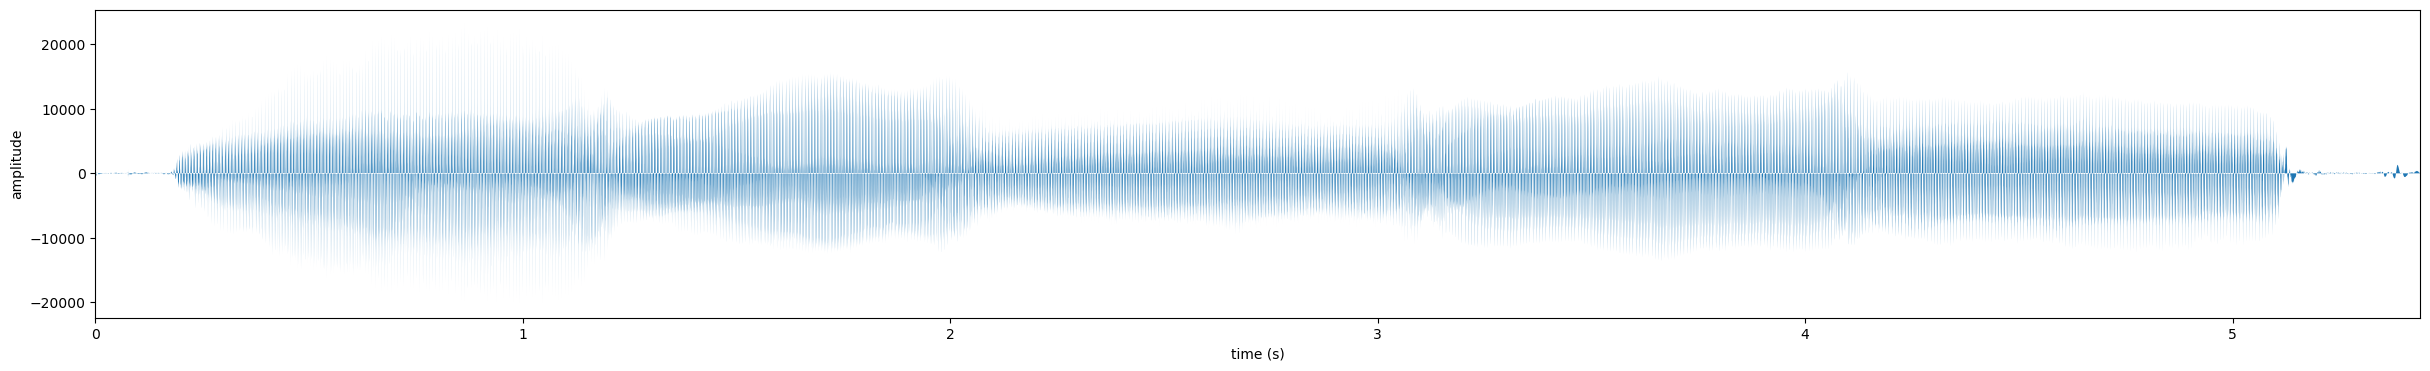

In [8]:
plot_sound(s, times)

In [9]:
# Function to write a new wave file and plot it
def write_and_plot(filename, y):
    write(filename, Fs, np.array(y, dtype=np.int16))
    data_path = os.getcwd()
    sound = os.path.join(data_path, filename)

    wavefile = load_sound(sound)
    print(wavefile.getparams())

    num_samples = int(wavefile.getnframes())
    data = wavefile.readframes(num_samples)
    data = struct.unpack('{n}h'.format(n=num_samples), data)
    x = np.array(data)

    timestep = 1/float(Fs)
    times = np.arange(len(x))*timestep

    plot_sound(x, times)
    return

# 1 Extraction of the analysis marks

For the extraction of the analysis marks, we will program the following function AnalysisPitchMarks(s,Fs). The arguments s and Fs respectively are the signal to be analyzed and the sampling frequency.

The returned matrix "A" will contain the times and pitches corresponding to each analysis mark. More precisely, the matrix "A" will be formed of three rows, such that:
- A(1,n) = ta(n) is the time corresponding to the $n^{th}$ analysis mark (ta(n) ∈ N is expressed in number of samples)
- A(2,n) = voiced(n) is a Boolean which indicates whether the signal is voiced or unvoiced in the neighborhood of this mark
- A(3,n) = Pa(n) ∈ N describes the pitch corresponding to the same mark (i.e. the period expressed in number of samples) in the voiced case, or equals 10ms × Fs in the unvoiced case.

Let us now detail how to determine the analysis marks. For the sake of simplicity, we will not try to align the mark ta(n) on the beginning of a glottal pulse. To compute Pa (n) and ta (n), we proceed by recursion on n ≥ 1:

- extraction of a sequence x that starts at time ta (n − 1), and whose duration is equal to 2.5 Pa(n-1)
- computation of Pa(n) and voiced(n) by means of function period
- computation of ta(n) = ta(n-1) + Pa(n)

The algorithm will be initialized by setting ta(0) = 0 and Pa(0) = 10ms × Fs.

In [10]:
def AnalysisPitchMarks(s,Fs) :
    
    n = len(s)
    
    t = 0
    v = 0
    P = int( 1 / 100 * Fs )
    
    # initial conditions of the algorithm
    ta = []
    ta.append(t)
    vo = []
    vo.append(v)
    Pa = []
    Pa.append(P)
    
    
    while (t + 2.5 * P) < n:

        idx1 = t + int(2.5*P)
        x = s[t:idx1]
        
        [P,v] = period(x,Fs)
        t += int(P)
        ta.append(t)
        vo.append(v)
        Pa.append(P)
    
    arr_ta = np.asarray(ta).reshape(1,-1)
    arr_vo = np.asarray(vo).reshape(1,-1)
    arr_Pa = np.asarray(Pa).reshape(1,-1)
    A = np.vstack((ta, vo, Pa),  dtype=object)
    
    return A


In [11]:
A = AnalysisPitchMarks(s, Fs)

We were able to integrate the concepts explained in class and effectively implement an algorithm for calculating the analysis marks. There weren't many difficulties for this implementation.

# 2 Synthesis and modification of the temporal and spectral scales

To perform the synthesis of the signal, we must start by defining the synthesis marks. They will be stocked in a matrix B formed of two rows, such that:
- B(1,k) = ts(k) is the time corresponding to the $k^{th}$ synthesis mark 
- B(2,k) = n(k) is the index of the analysis mark corresponding to this same synthesis mark

To start, we can perform a synthesis without modifications, by setting:
- B(1,:) = A(1,:);
- B(2,:) = [1, 2, 3, . . .];

In [12]:
# Matrix with the synthesis marks
n = len(A[0,:])
B = np.zeros((2, n), dtype=object)
B[0,:] = A[0,:]
B[1,:] = np.arange(n)

## 2.1 Signal synthesis

We will now program the following function Synthesis(s,Fs,A,B) which computes the synthesis signal y from the original signal s, the sampling frequency Fs, the analysis marks stocked in matrix A and the synthesis marks stocked in matrix B. The synthesis is very simply performed by recursion on k ≥ 1 (vector y being initialized to the zero vector of dimension ts(kend) + Pa (n(kend))):
- extraction of a sequence x centered at ta(n(k)) and of length 2Pa(n(k)) + 1;
- windowing of x by a Hann window
- overlap-add of the sequence x windowed on y(ts(k) - Pa(n(k)) : ts(k) + Pa(n(k))).

In [13]:
def Synthesis(s, Fs, A, B):
    
    y = np.zeros(B[0,-1] + int(A[2,B[1,-1]]))
    k = 0
    ta = int(A[0,B[1,0]])
    Pa = int(A[2,B[1,0]])
    ts = B[0,k]
    
    while (ta - Pa - 1 <= 0) | (ts - Pa - 1 <= 0):
        k = k + 1
        ta = int(A[0,B[1,k]])
        Pa = int(A[2,B[1,k]])
        ts = B[0,k]
    
    while k < len(B[1,:]) - 1:
        ta = int(A[0,B[1,k]])
        Pa = int(A[2,B[1,k]])
        idx0 = ta - Pa - 1
        idx1 = ta + Pa
        x = s[idx0:idx1]
        w = signal.hann(2*Pa + 1)
        x = x * w
        ts = B[0,k]
        idx0 = ts - Pa - 1
        idx1 = ts + Pa
        y[idx0:idx1] = y[idx0:idx1] + x
        k = k + 1
    
    
    return y

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59800, comptype='NONE', compname='not compressed')


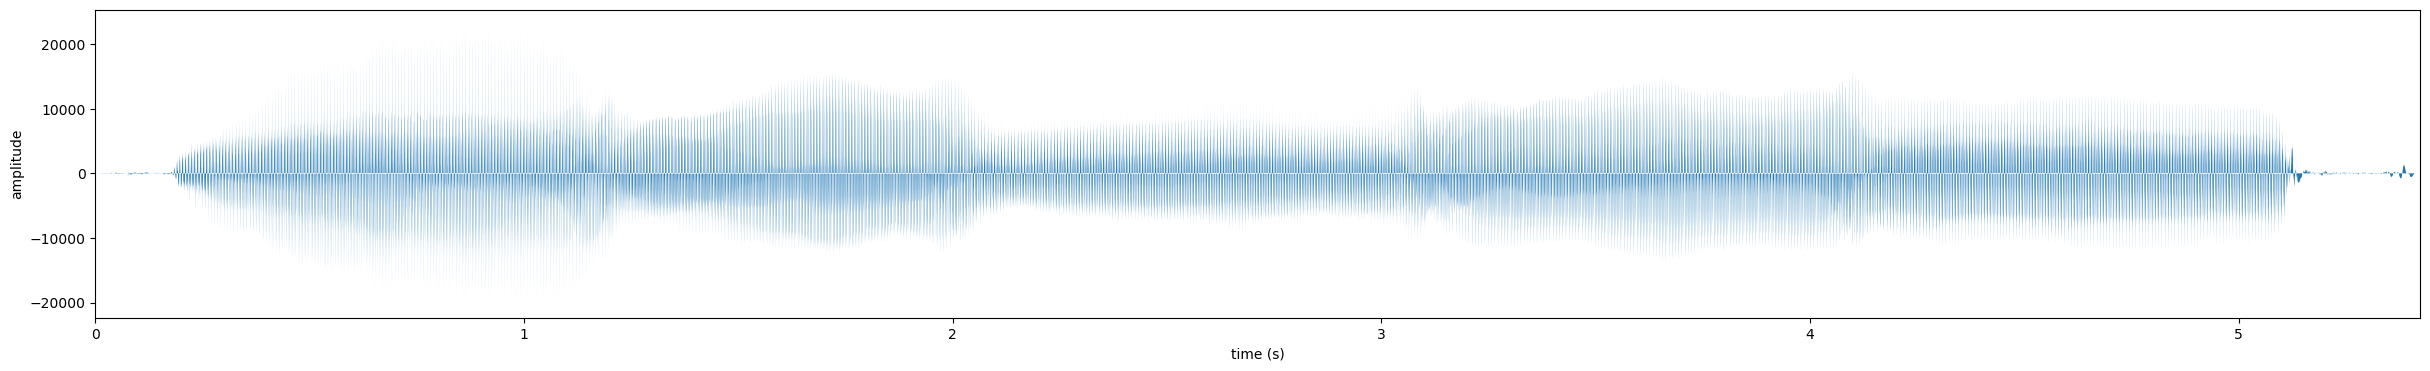

In [14]:
# We can now synthesize the signal without modification of the temporal and spectral scales
y = Synthesis(s, Fs, A, B)
write_and_plot('aeiou_perfect_reconst.wav', y)

In [15]:
IPython.display.Audio('aeiou_perfect_reconst.wav')

We were able to implement the synthesis algorithm, we tested it making the synthesis of our original signal without modificating the synthesis marks and obtaining a perfect reconstruction.

## 2.2 Modification of the temporal scale

We now want to determine the synthesis marks that will modify the temporal scale by a factor $\alpha$, i.e. to determine a matrix B such that the duration of the signal synthesized by function Synthesis is equal to that of the original signal s multiplied by $\alpha$. This operation will be performed by the function ChangeTimeScale(alpha,A,Fs) which computes matrix B from the factor $\alpha$, the analysis marks stocked in A, and the sampling frequency Fs. You can proceed by recursion on k ≥ 1, by using a non-integer index n(k):

- ts(k) = ts(k - 1) + Pa(n(k))
- n(k+1) = n(k) + 1/$\alpha$

The algorithm will be initialized by setting ts(0) = 1 and n(1) = 1. You will take care of only stocking integer values in matrix B.

In [16]:
def ChangeTimeScale(alpha, A ,Fs):
    t = 1
    n = 1
        
    ts = []
    ts.append(1)
    nk = []
    nk.append(1)
    
    while n < len(A[2,:]) - 1:
        t = t + A[2,int(n)]
        ts.append(int(t))
        n = n + 1/alpha
        nk.append(int(n))
    
    ts = np.asarray(ts)
    nk = np.asarray(nk)
    
    B = np.vstack((ts, nk))
    
    return B
    

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=119271, comptype='NONE', compname='not compressed')


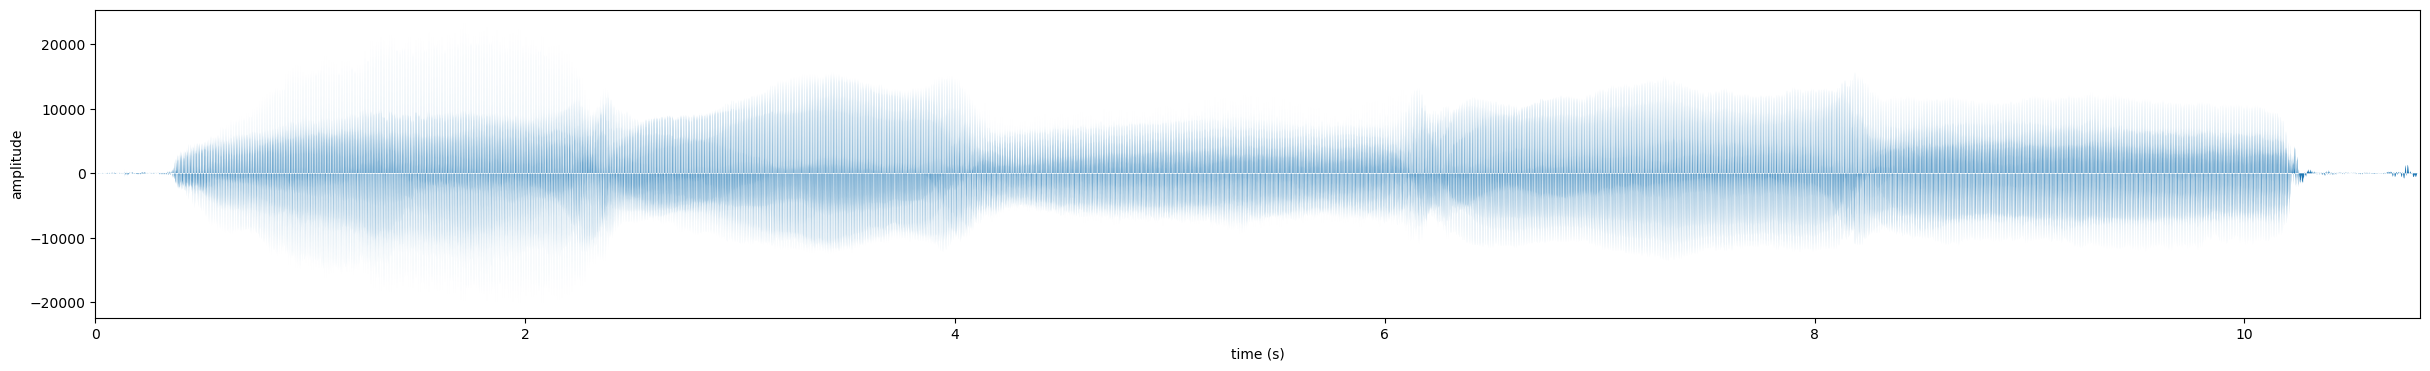

In [17]:
B = ChangeTimeScale(2, A, Fs)
y = Synthesis(s, Fs, A, B)
write_and_plot('aeiou_time_extended.wav', y)

In [18]:
IPython.display.Audio('aeiou_time_extended.wav')

We were able to implement the modification of temporal scale algorithm, we try it modifying the original signal and making it two times longer with $\alpha = 2$. The result can be seen in the plot and also listened in the new audio synthesis. There were no major drawbacks during the implementation of the algorithm.

## 2.3 Modification of the spectral scale

We will now perform the dual operation of the previous one: determine the synthesis marks that will modify the spectral scale by a factor $\beta$, i.e. determine a matrix B such that the fundamental frequency of the signal synthesized by function Synthesis is equal to that of the original signal s multiplied by $\beta$.

This operation will be performed by the function B = ChangePitchScale(beta,A,Fs) which computes matrix B from the factor $\beta$, the analysis marks stocked in A, and the sampling frequency Fs. As in the previous case, we can proceed by recursion on k ≥ 1, by using a non-integer index n(k) and non-integer synthesis times ts(k), and by making the difference between the voiced and unvoiced
cases:

- if the analysis mark of index bn(k)c is voiced, scale(k) = 1/$\beta$ , otherwise scale(k) = 1;
- ts(k) = ts(k-1) + scale(k) × Pa(n(k))
- n(k+1) = n(k) + scale(k)

In [19]:
def ChangePitchScale(beta,A,Fs):
    
    voiced = A[1,:]
    Pa = A[2,:]
    
    t = 1
    n = 1
    
    ts = []
    ts.append(t)
    nk = []
    nk.append(n)
    
    while int(n) < len(voiced) - 1:
        if voiced[int(n)] == 1:
            scale = 1/beta
        else:
            scale = 1
        t += scale*Pa[int(n)]
        ts.append(int(t))
        n += scale
        nk.append(int(n))
        
    ts = np.asarray(ts)
    nk = np.asarray(nk)
    
    B = np.vstack((ts, nk))
    
    return B
    
    
    

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59691, comptype='NONE', compname='not compressed')


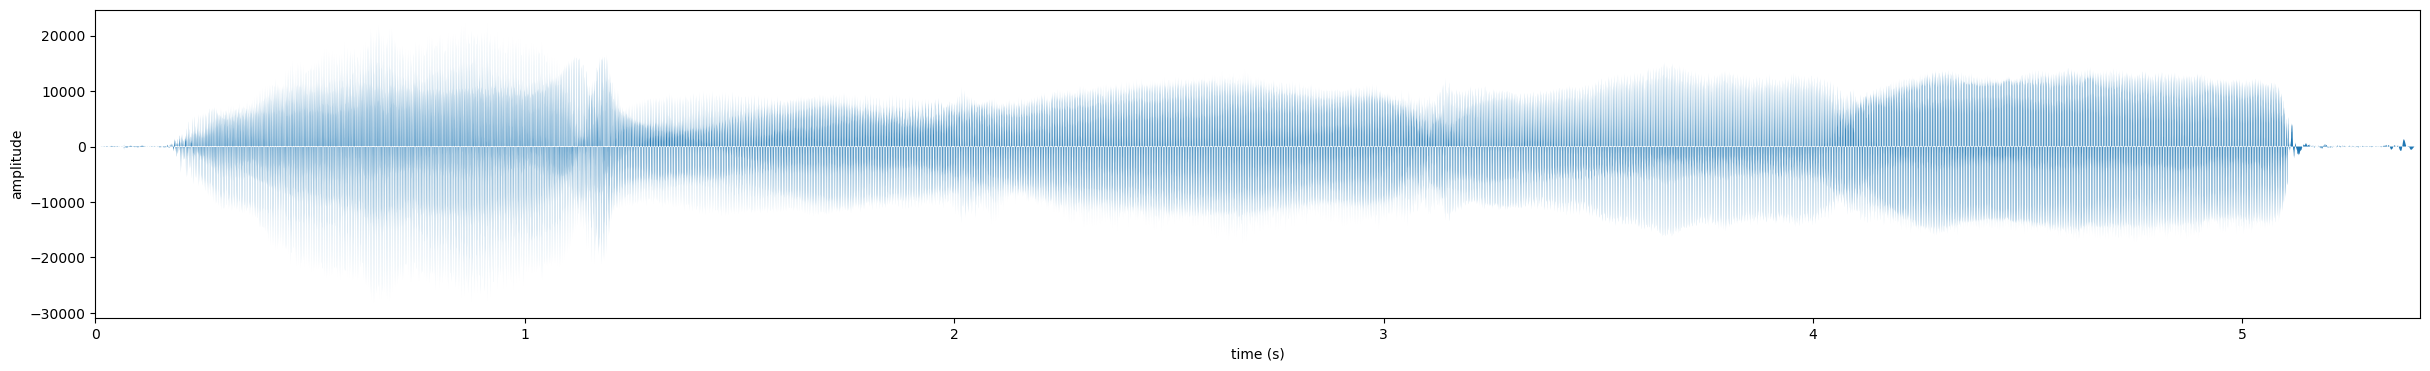

In [20]:
B = ChangePitchScale(2, A, Fs)
y = Synthesis(s, Fs, A, B)
write_and_plot('aeiou_pitch_increased.wav', y)

In [21]:
IPython.display.Audio('aeiou_pitch_increased.wav')

Once again we implemented the modification of the spectral scale algorithm without problems and it works as expected. In the example we increased the pitch of the original audio signal by a factor $\beta=2$.

## 2.4 Joint modification of the temporal and spectral scales

Finally we implemented a function ChangeBothScales(alpha,beta,A,Fs) for changing both scales at the same time, by slightly modifying the previous algorithms we obtain the desired function.

In [22]:
def ChangeBothScales(alpha,beta,A,Fs):
    
    voiced = A[1,:]
    Pa = A[2,:]
    
    t = 1
    n = 1
    
    ts = []
    ts.append(t)
    nk = []
    nk.append(n)
    
    while int(n) < len(voiced) - 1:
        if voiced[int(n)] == 1:
            scale = 1/beta
        else:
            scale = 1
        t += scale*Pa[int(n)]
        ts.append(int(t))
        n += scale/alpha
        nk.append(int(n))
        
    ts = np.asarray(ts)
    nk = np.asarray(nk)
    
    B = np.vstack((ts, nk))
    
    return B

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=119271, comptype='NONE', compname='not compressed')


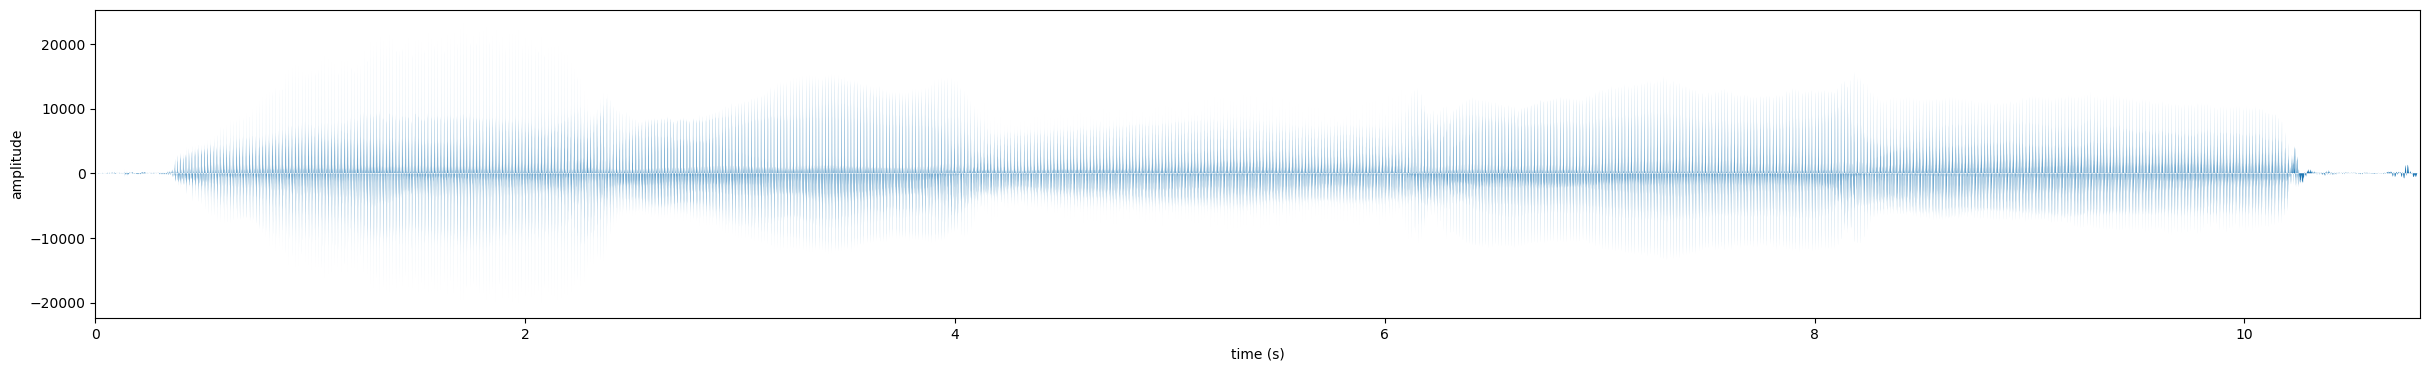

In [23]:
B = ChangeBothScales(2, 0.5, A, Fs)
y = Synthesis(s, Fs, A, B)
write_and_plot('aeiou_time_ext_pitch_decr.wav', y)

In [24]:
IPython.display.Audio('aeiou_time_ext_pitch_decr.wav')

The function works properly and the test example in this case is the signal extended in time by a factor 2 and pitch decreased by also a factor of 2.